In [1]:
from PIL import Image
import numpy as np
from matplotlib import cm
from IPython.display import display

In [2]:
def cosines_signal(coords, freqs, amps=1.0, phases=0.0, normalized=True):
    """A signal composed as a sum of cosines. Each cosine has a given frequency, amplitude and phase."""
    amps = amps / np.sum(amps) if normalized else amps
    cycles = coords * np.atleast_2d(freqs).T + np.atleast_2d(phases).T
    return np.sum(np.atleast_2d(amps).T * (np.cos(cycles * 2 * np.pi)/2 + 0.5), axis=0)

def compute_coordinates(res, size):
    """Return an array of shape (res) containing the coordinates of a sampling lattice."""
    pitch = size / res
    indices = np.arange(res)
    return (indices - (res - 1)/2) * pitch

def display_image(values, color_map=None):
    """Display an image using the given color map."""
    color_values = cm.get_cmap(color_map)(values/np.amax(values))
    uint8_values = (color_values * 255).astype(np.uint8)
    display(Image.fromarray(uint8_values).transpose(Image.ROTATE_90))

In [3]:
pixel_size = 31
low_res = 33
high_res = low_res * pixel_size

impulse = [0.0]*(pixel_size//2) + [1.0] + [0.0]*(pixel_size//2)
impulse_train = impulse * low_res

high_res_coords = compute_coordinates(high_res, low_res)
low_res_coords  = compute_coordinates( low_res, low_res)

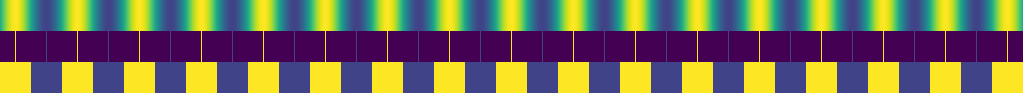

In [4]:
nyquist = cosines_signal(high_res_coords, [0.5], [1.0]) * 0.8 + 0.2
sampled = nyquist * impulse_train
box_reconstruction = np.convolve(sampled, np.ones(pixel_size), mode='same')

img = np.stack((nyquist, sampled, box_reconstruction), axis=1)
display_image(np.repeat(np.flip(img, axis=1), pixel_size, axis=1))

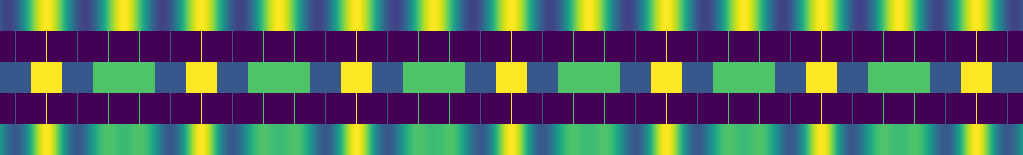

In [5]:
sub_nyquist = cosines_signal(high_res_coords, [0.4], [1.0]) * 0.8 + 0.2
sampled = sub_nyquist * impulse_train
box_reconstruction = np.convolve(sampled, np.ones(pixel_size), mode='same')

perceived = cosines_signal(high_res_coords, [0.4, 0.6], [np.sinc(0.4), np.sinc(0.6)]) * 0.8 + 0.2
sampled2 = perceived * impulse_train

img = np.stack((sub_nyquist, sampled, box_reconstruction, sampled2, perceived), axis=1)
display_image(np.repeat(np.flip(img, axis=1), pixel_size, axis=1))

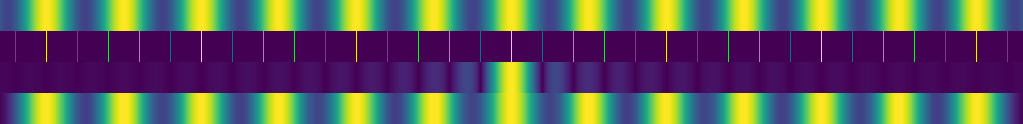

In [6]:
sub_nyquist = cosines_signal(high_res_coords, [0.4], [1.0]) * 0.8 + 0.2
sampled = sub_nyquist * impulse_train
ideal_filter = np.abs(np.sinc(high_res_coords))
ideal_reconstruction = np.clip(np.convolve(sampled, np.sinc(high_res_coords), mode='same'), 0.0, 1.0)

img = np.stack((sub_nyquist, sampled, ideal_filter, ideal_reconstruction), axis=1)
display_image(np.repeat(np.flip(img, axis=1), pixel_size, axis=1))

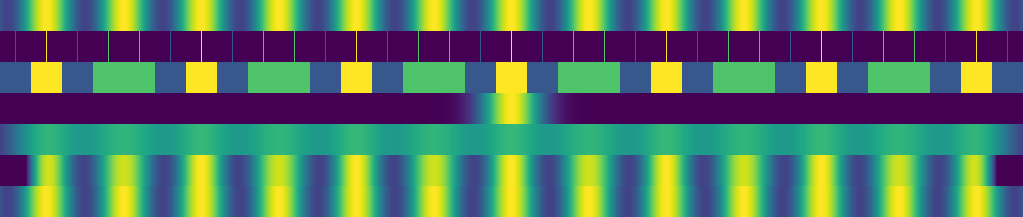

In [7]:
sub_nyquist = cosines_signal(high_res_coords, [0.4], [1.0]) * 0.8 + 0.2
sampled = sub_nyquist * impulse_train
box_reconstruction = np.convolve(sampled, np.ones(pixel_size), mode='same')

blur_kernel = np.exp(-np.square(high_res_coords))

blured = np.convolve(box_reconstruction, blur_kernel, mode='same') / np.sum(blur_kernel)

blured_contrast = blured - np.amin(blured[4*pixel_size:-4*pixel_size])
blured_contrast = blured_contrast / np.amax(blured_contrast) * 0.8 + 0.2

img = np.stack((sub_nyquist, sampled, box_reconstruction, blur_kernel, blured, blured_contrast, sub_nyquist), axis=1)
display_image(np.repeat(np.flip(img, axis=1), pixel_size, axis=1))